In [2]:
%run 'data_preparation.ipynb'

In [3]:
#%store -r schoolholidays
#%store -r year
#%store -r data

In [4]:
import warnings

In [53]:
from fbprophet import Prophet
import ml_metrics as metrics

In [54]:
#run this cell for total number of cars
per_day = year.pivot_table(index=['BOOKING_DATE'],values=['VEHICLE_HAL_ID'], aggfunc=lambda x: len(x.unique()))

In [55]:
#run this cell for number of cars for a specific city
#city = year.loc[year['CITY_RENTAL_ZONE']=='Hamburg']
#per_day = city.pivot_table(index=['BOOKING_DATE'],values=['VEHICLE_HAL_ID'], aggfunc=lambda x: len(x.unique()))

In [56]:
#fullcity = data.loc[data['CITY_RENTAL_ZONE']=='Hamburg']
per_day_2017 = data.pivot_table(index=['BOOKING_DATE'],values=['VEHICLE_HAL_ID'], aggfunc=lambda x: len(x.unique()))

In [57]:
per_day.reset_index(inplace=True)
per_day.tail()

,BOOKING_DATE,VEHICLE_HAL_ID
1091,2016-12-27,213
1092,2016-12-28,202
1093,2016-12-29,223
1094,2016-12-30,223
1095,2016-12-31,188


In [58]:
#log-transform as a way to remove some of the anomolies
per_day.VEHICLE_HAL_ID = np.log(per_day.VEHICLE_HAL_ID)

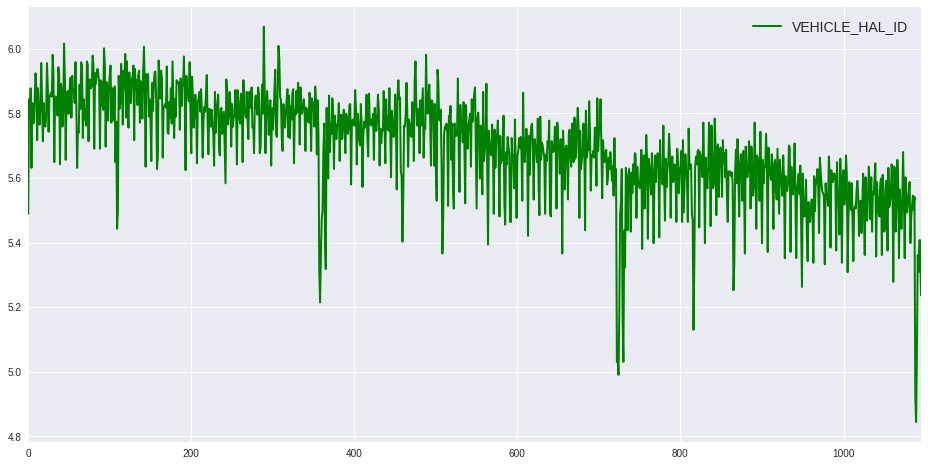

In [59]:
per_day.plot(color='green')

# Prediction without holiday data

In [60]:
# Prophet requires columns ds (Date) and y (value)
per_day = per_day.rename(columns={'BOOKING_DATE': 'ds', 'VEHICLE_HAL_ID': 'y'})
# Make the prophet model and fit on the data
per_day_prophet = Prophet(changepoint_prior_scale=0.4, changepoints=['2014-04-16', '2014-12-17','2014-12-17', '2015-01-21', '2015-05-07', '2015-08-20', '2016-01-07', '2016-04-21'])

per_day_prophet.add_seasonality(name='monthly', period=30.5, fourier_order=5, prior_scale=0.2)
per_day_prophet.fit(per_day)
# Make a future dataframe for 2 years
per_day_forecast = per_day_prophet.make_future_dataframe(periods=730, freq='D')
# Make predictions
per_day_forecast = per_day_prophet.predict(per_day_forecast)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/jawahar/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



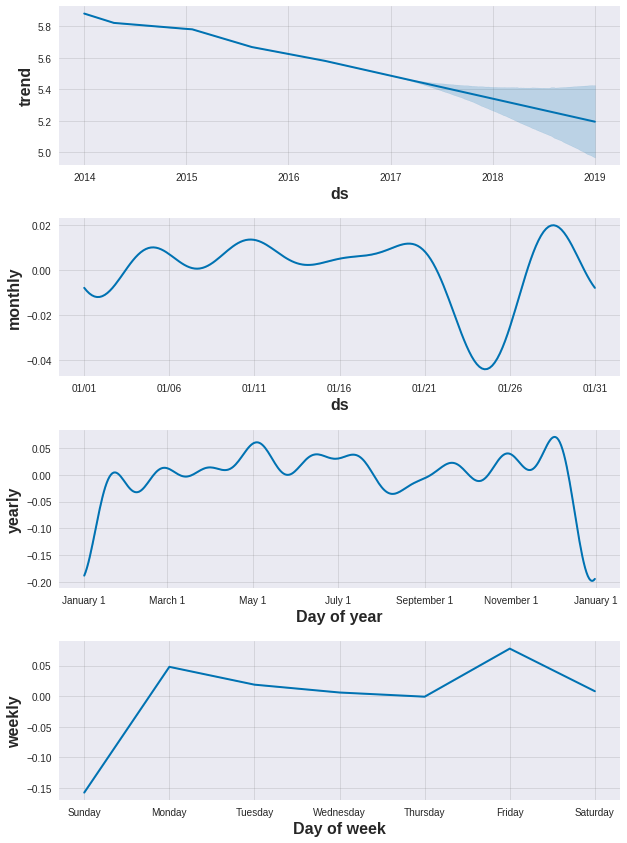

In [61]:
per_day_prophet.plot_components(per_day_forecast);

In [62]:
viz_df = per_day.join(per_day_forecast[['yhat', 'yhat_lower','yhat_upper']], how = 'outer')
viz_df['yhat_scaled']=np.exp(viz_df['yhat'])
viz_df['y']=np.exp(viz_df['y'])

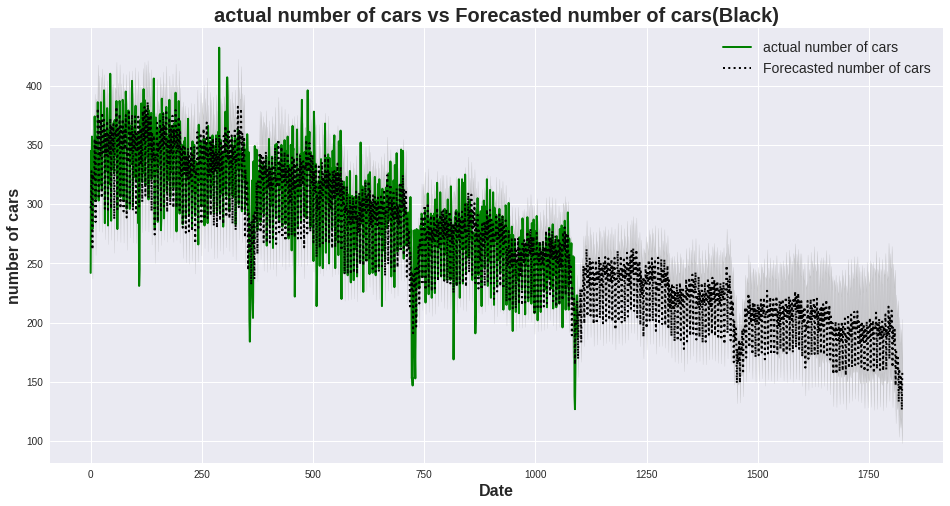

In [63]:
fig, ax1 = plt.subplots()
ax1.plot(viz_df.y, color='green')
ax1.plot(viz_df.yhat_scaled, color='black', linestyle=':')
ax1.fill_between(viz_df.index, np.exp(viz_df['yhat_upper']), np.exp(viz_df['yhat_lower']), alpha=0.5, color='darkgray')
ax1.set_title('actual number of cars vs Forecasted number of cars(Black)')
ax1.set_ylabel('number of cars')
ax1.set_xlabel('Date')

L=ax1.legend() #get the legend
L.get_texts()[0].set_text('actual number of cars') #change the legend text for 1st plot
L.get_texts()[1].set_text('Forecasted number of cars') #change the legend text for 2nd plot

In [64]:
per_day_prophet.changepoints

DatetimeIndex(['2014-04-16', '2014-12-17', '2014-12-17', '2015-01-21',
               '2015-05-07', '2015-08-20', '2016-01-07', '2016-04-21'],
              dtype='datetime64[ns]', freq=None)

In [65]:
#changepoints=['2014-04-16', '2014-12-17','2014-12-17', '2015-01-21', '2015-05-07', '2015-08-20', '2016-01-07', '2016-04-21']

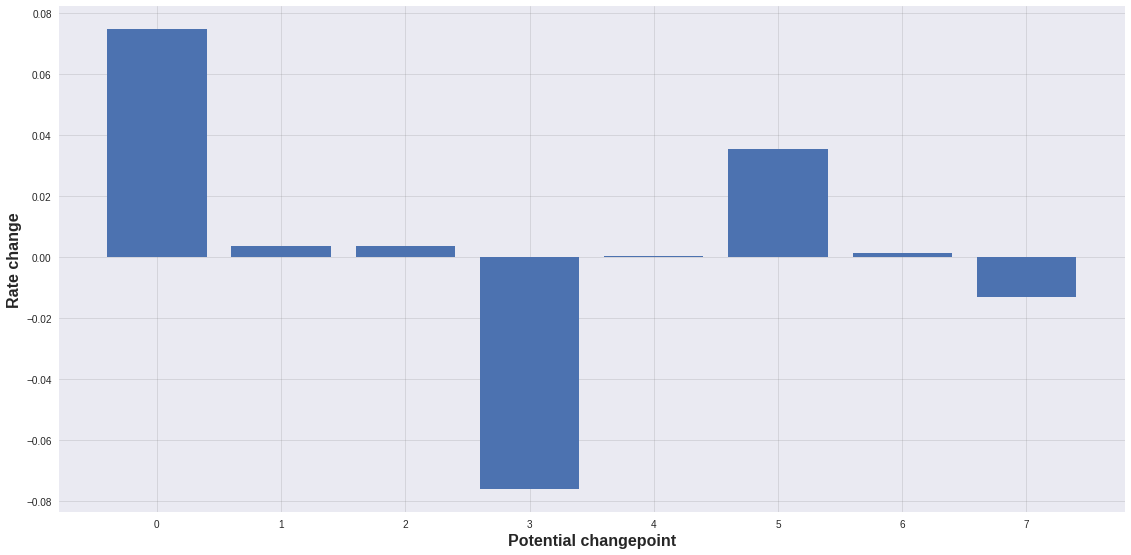

In [66]:
deltas = per_day_prophet.params['delta'].mean(0)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111)
ax.bar(range(len(deltas)), deltas)
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax.set_ylabel('Rate change')
ax.set_xlabel('Potential changepoint')
fig.tight_layout()

# Effect of Changepoint Prior Scale

In [67]:
cpscale = pd.DataFrame(per_day)

In [68]:
# Try 4 different changepoints
for changepoint in [0.1, 0.2, 0.27 ,0.3, 0.31, 0.32, 0.33, 0.4, 0.43, 0.45, 0.49]:
    model = Prophet(daily_seasonality=False, changepoint_prior_scale=changepoint)
    model.fit(cpscale)
    
    future = model.make_future_dataframe(periods=730, freq='D')
    future = model.predict(future)
    
    cpscale[changepoint] = future['yhat']
    #cpscale.columns = cpscale.columns.astype(str)
    print("RMSE for Changepoint Prior Scale "+ str(changepoint))
    print(metrics.rmse(cpscale['y'], cpscale[changepoint]))
    print('\n')
    

/home/jawahar/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



RMSE for Changepoint Prior Scale 0.1
0.07641252074782291


RMSE for Changepoint Prior Scale 0.2
0.07631478966471753


RMSE for Changepoint Prior Scale 0.27
0.07627251845221979


RMSE for Changepoint Prior Scale 0.3
0.0762581948315088


RMSE for Changepoint Prior Scale 0.31
0.07625042543323703


RMSE for Changepoint Prior Scale 0.32
0.07625814234811071


RMSE for Changepoint Prior Scale 0.33
0.07625888307546459


RMSE for Changepoint Prior Scale 0.4
0.0762250075579179


RMSE for Changepoint Prior Scale 0.43
0.07622591710182114


RMSE for Changepoint Prior Scale 0.45
0.07621716530402543


RMSE for Changepoint Prior Scale 0.49
0.07616129805400085




# Prediction with holiday data

In [69]:
schoolholidays.columns

Index(['Berlin', 'Hamburg', 'BadenWürttemberg', 'Bayern', 'Brandenburg',
       'Bremen', 'Hessen', 'MecklenburgVorpommern', 'Niedersachsen',
       'NordrheinWestfalen', 'RheinlandPfalz', 'Saarland', 'Sachsen',
       'SachsenAnhalt', 'SchleswigHolstein', 'Thüringen'],
      dtype='object')

In [70]:
holidays = pd.DataFrame({
  'holiday': 'school-holidays',
  'ds': schoolholidays.Hamburg,
  'lower_window': 0,
  'upper_window': 2,
});

In [71]:
holidays.head()

,ds,holiday,lower_window,upper_window
0,2014-01-01,school-holidays,0,2
1,2014-01-02,school-holidays,0,2
2,2014-01-03,school-holidays,0,2
3,2014-01-31,school-holidays,0,2
4,2014-03-03,school-holidays,0,2


In [72]:
# Make the prophet model and fit on the data
model = Prophet(holidays=holidays, changepoint_prior_scale=0.4, changepoints=['2014-04-16', '2014-12-17','2014-12-17', '2015-01-21', '2015-05-07', '2015-08-20', '2016-01-07', '2016-04-21'])
# Add daily seasonility
model.add_seasonality(name='daily', period=24, fourier_order=5, prior_scale=0.1);
# Add monthly seasonility
model.add_seasonality(name='monthly', period=30.5, fourier_order=5, prior_scale=0.1);
# Fit the data
model.fit(per_day)
# Make prediction for next 2 years
future = model.make_future_dataframe(periods=730, freq = 'D')
forecast = model.predict(future)

INFO:fbprophet.forecaster:Found custom seasonality named "daily", disabling built-in daily seasonality.
/home/jawahar/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



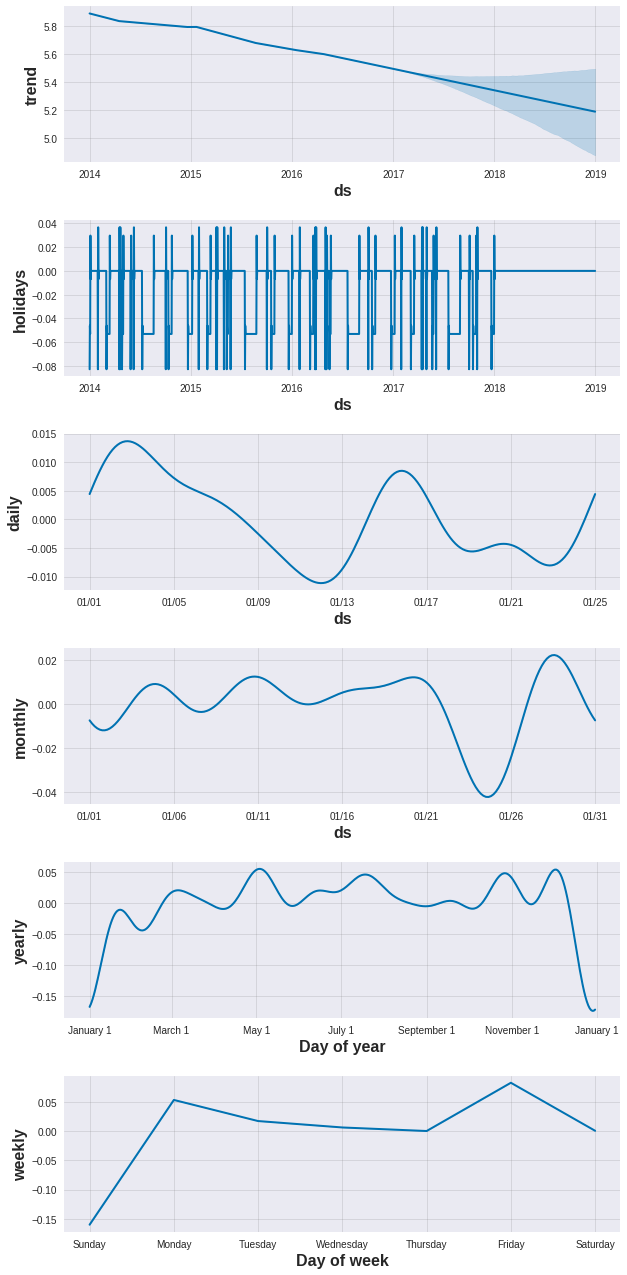

In [73]:
model.plot_components(forecast);

In [74]:
hviz_df = per_day.join(forecast[['yhat', 'yhat_lower','yhat_upper']], how = 'outer')

In [75]:
hviz_df['yhat_scaled']=np.exp(hviz_df['yhat'])
hviz_df['y']=np.exp(hviz_df['y'])

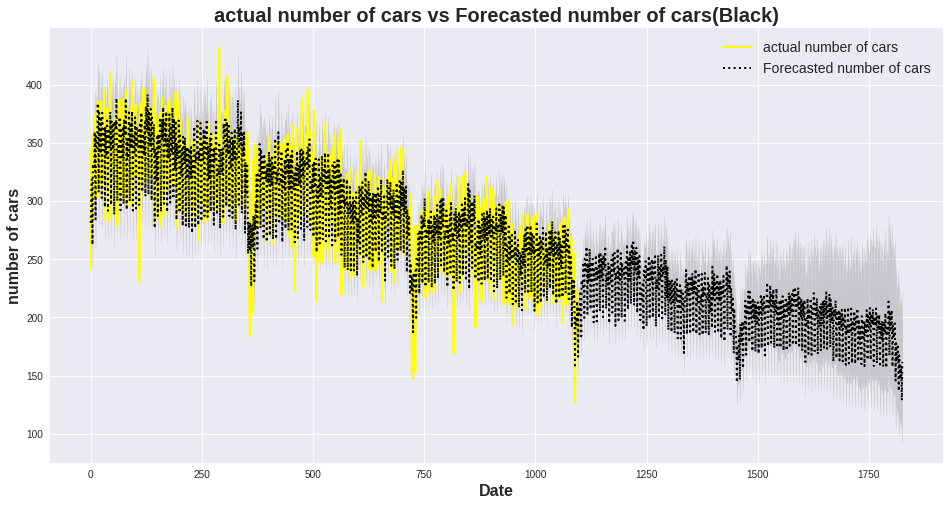

In [76]:
fig, ax1 = plt.subplots()
ax1.plot(hviz_df.y, color='yellow')
ax1.plot(hviz_df.yhat_scaled, color='black', linestyle=':')
ax1.fill_between(hviz_df.index, np.exp(hviz_df['yhat_upper']), np.exp(hviz_df['yhat_lower']), alpha=0.5, color='darkgray')
ax1.set_title('actual number of cars vs Forecasted number of cars(Black)')
ax1.set_ylabel('number of cars')
ax1.set_xlabel('Date')

L=ax1.legend() #get the legend
L.get_texts()[0].set_text('actual number of cars') #change the legend text for 1st plot
L.get_texts()[1].set_text('Forecasted number of cars') #change the legend text for 2nd plot

# changepoints

In [77]:
model.changepoints

DatetimeIndex(['2014-04-16', '2014-12-17', '2014-12-17', '2015-01-21',
               '2015-05-07', '2015-08-20', '2016-01-07', '2016-04-21'],
              dtype='datetime64[ns]', freq=None)

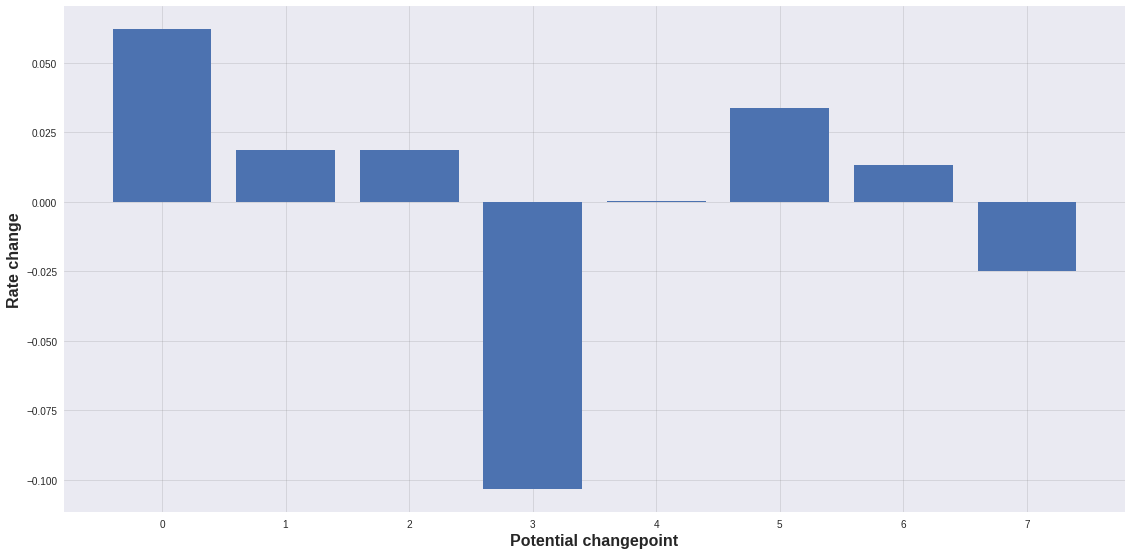

In [78]:
deltas = model.params['delta'].mean(0)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111)
ax.bar(range(len(deltas)), deltas)
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax.set_ylabel('Rate change')
ax.set_xlabel('Potential changepoint')
fig.tight_layout()

In [79]:
compared_df = forecast.join(per_day_forecast, rsuffix="_no_holiday")

Creating compared_viz DataFrame

In [80]:
    compared_viz_df = compared_df[['ds','yhat', 'yhat_no_holiday']]

    compared_viz_df['yhat']= np.exp(compared_viz_df['yhat'])
    compared_viz_df['yhat_no_holiday']= np.exp(compared_viz_df['yhat_no_holiday'])

    cols = ['yhat', 'yhat_no_holiday']
    compared_viz_df[cols] = compared_viz_df[cols].applymap(np.int64)


/home/jawahar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/jawahar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/jawahar/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:2450: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-d

In [81]:
compared_viz_df.tail()

,ds,yhat,yhat_no_holiday
1821,2018-12-27,146,142
1822,2018-12-28,158,153
1823,2018-12-29,147,145
1824,2018-12-30,128,126
1825,2018-12-31,161,158


In [82]:
compared_df = compared_df[['yhat', 'yhat_no_holiday']]

computing the mean of the difference

# Mean of the difference between holiday and non-holiday

In [83]:
compared_dfexp= compared_df[['yhat', 'yhat_no_holiday']]

In [84]:
compared_dfexp['diff_per'] = 100*(compared_dfexp['yhat'] - compared_dfexp['yhat_no_holiday']) / compared_dfexp['yhat_no_holiday']

In [85]:
compared_dfexp.tail()

,yhat,yhat_no_holiday,diff_per
1821,4.989598,4.960310,0.590455
1822,5.066533,5.036124,0.603810
1823,4.996956,4.982083,0.298524
1824,4.857242,4.840527,0.345316
1825,5.085419,5.065300,0.397195


In [86]:
compared_dfexp['diff_per'].mean()

-0.025697328365547323

Creating a result dataframe for plotting

In [87]:
result_df = per_day.join(compared_df, rsuffix="del")
result_df = result_df.rename(columns={'ds':'BOOKING_DATE','y':'VEHICLE_HAL_ID'})
    
result_df['VEHICLE_HAL_ID']= np.exp(result_df['VEHICLE_HAL_ID'])
result_df['yhat']= np.exp(result_df['yhat'])
result_df['yhat_no_holiday']= np.exp(result_df['yhat_no_holiday'])
    
cols = ['VEHICLE_HAL_ID','yhat', 'yhat_no_holiday']
result_df[cols] = result_df[cols].applymap(np.int64)
    

In [88]:
result_df.tail()

,BOOKING_DATE,VEHICLE_HAL_ID,0.1,yhat,yhat_no_holiday
1091,2016-12-27,213,5.313371,193,198
1092,2016-12-28,202,5.297594,195,199
1093,2016-12-29,223,5.289839,197,201
1094,2016-12-30,223,5.369680,213,218
1095,2016-12-31,188,5.302806,195,201


# Measuring the accuracy of the FbProphet model

In [89]:
#using ml metrics

In [90]:
import ml_metrics as metrics

RMSE with holiday data

In [91]:
metrics.rmse(result_df.VEHICLE_HAL_ID, result_df.yhat)

19.840950611497504

RMSE without holiday data

In [92]:
metrics.rmse(result_df.VEHICLE_HAL_ID, result_df.yhat_no_holiday)

20.691644704661385

# interactive plotting with plotly

In [93]:
#changecolor

In [94]:
trace0 = go.Scatter(
    x = result_df.BOOKING_DATE,
    y = result_df.VEHICLE_HAL_ID,
    mode = 'lines',
    name = 'actual number of cars used'
)
trace1 = go.Scatter(
    x = result_df.BOOKING_DATE,
    y = result_df.yhat,
    mode = 'lines',
    name = 'number of cars with holiday data'
)
trace2 = go.Scatter(
    x = result_df.BOOKING_DATE,
    y = result_df.yhat_no_holiday,
    mode = 'lines',
    name = 'number of cars with out holiday data'
)
layout = go.Layout(title="observations from FbProphet model",
                yaxis=dict(title='number of cars')
                )
fig = go.Figure(data=[trace0, trace1, trace2], layout=layout)
py.iplot(fig, filename="Observations from FbProphet")

In [95]:
trace0 = go.Scatter(
    x = compared_viz_df.ds,
    y = per_day_2017.VEHICLE_HAL_ID,
    mode = 'lines',
    name = 'actual number of cars used'
)
trace1 = go.Scatter(
    x = compared_viz_df.ds,
    y = compared_viz_df.yhat,
    mode = 'lines',
    name = 'number of cars used with holiday data'
)
trace2 = go.Scatter(
    x = compared_viz_df.ds,
    y = compared_viz_df.yhat_no_holiday,
    mode = 'lines',
    name = 'number of cars used with out holiday data'
)
layout = go.Layout(title="observations from FbProphet model with next 2 years prediction",
                yaxis=dict(title='number of cars used')
                )
fig = go.Figure(data=[trace0, trace1, trace2], layout=layout)
py.iplot(fig, filename="Observations from FbProphet")

# Observations

# RMSE values for the model

model with holidays data

Model without holidays data